In [1]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
import math
import itertools
import gurobipy as gp 
from gurobipy import GRB
import numpy as np


In [2]:
def rectangularSMART(c,a,b):
    
    numRect = 1
    found = []
    
    m = gp.Model("Rectangular Method")
    
    n = a.shape[0]
    cons = b.shape[0]
    

    Items=list(np.arange(n))
    Dimensions= list(np.arange(cons))
    # Decision Vars
    x = m.addVars(n,vtype=GRB.BINARY, name="ToTakeOrNotToTake")

    #Mute Output Text
    m.Params.OutputFlag = 0


    #Knapsack Constraints
    for j in Dimensions:
        m.addConstr(gp.quicksum(x[i]*a[i,j] for i in Items) <= b[j], name="j"+str(j))

    #NW 
    m.setObjective(gp.quicksum(x[i]*c[0,i] for i in Items), GRB.MINIMIZE)
    m.optimize()
    if m.status != 2:
        return [],1
    lexConstraint = round(m.objVal)
    m.setObjective(gp.quicksum(x[i]*c[1,i] for i in Items), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(x[i]*c[0,i] for i in Items) <= lexConstraint, name = 'temp')
    m.optimize()
    hold = round(m.objVal)
    NW = (lexConstraint,hold)
    
    #SE 
    old = m.getConstrByName('temp')
    m.remove(old)
    m.setObjective(gp.quicksum(x[i]*c[1,i] for i in Items), GRB.MINIMIZE)
    m.optimize()
    lexConstraint = round(m.objVal)
    m.setObjective(gp.quicksum(x[i]*c[0,i] for i in Items), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(x[i]*c[1,i] for i in Items) <= lexConstraint, name = 'temp')
    m.optimize()
    hold = round(m.objVal)
    SE = (hold, lexConstraint)
    
    old = m.getConstrByName('temp')
    m.remove(old)
    
    rectangles = [[NW,SE]]
    
    found.append(list(NW))
    if NW == SE:
        return found, numRect
    found.append(list(SE))
    
    #points in () , tuples
    #rectangles 2D lists of points 
    #5
    while len(rectangles) != 0:
        #6&7
        R = rectangles.pop(0)
        if R[1][0] - R[0][0] == 1:
            continue
        if R[0][1] - R[1][1] == 1:
            continue
        #8
        R2 = [(R[0][0] , (R[0][1]+R[1][1])/2.0), R[1] ] 
        
        
        #lexmin(z1,z2) MAKE SURE IN R2 (going left)
        m.addConstr(gp.quicksum(x[i]*c[1,i] for i in Items) <= R2[0][1], name = 'top bound')
        
        m.setObjective(gp.quicksum(x[i]*c[0,i] for i in Items), GRB.MINIMIZE)
        m.optimize()
        
        z1 = round(m.objVal)
        m.setObjective(gp.quicksum(x[i]*c[1,i] for i in Items), GRB.MINIMIZE)
        m.addConstr(gp.quicksum(x[i]*c[0,i] for i in Items) <= z1, name = 'temp')
        m.optimize()
        hold = round(m.objVal)
        old = m.getConstrByName('temp')
        m.remove(old)
        old = m.getConstrByName('top bound')
        m.remove(old)
        #9
        tempNW = (z1,hold) 
        #10/11/12
        if tempNW != R[1]:
            found.append(list(tempNW))
            rectangles.append([tempNW, R[1]])
        #13  
        R3 = [R[0],      (tempNW[0] - 1, ((R[0][1] + R[1][1])/2.0) + .001)]
        
               
               
        #lexmin(z2,z1) = z_opt    
        m.setObjective(gp.quicksum(x[i]*c[1,i] for i in Items), GRB.MINIMIZE)
        m.addConstr(gp.quicksum(x[i]*c[0,i] for i in Items) <= R3[1][0], name = 'right bound')
        #m.addConstr(gp.quicksum(x[i]*c[1,i] for i in Items) >= R3[1][1], name = 'bottom bound')
        
        m.optimize()
        
        z1=round(m.objVal)
        
        m.setObjective(gp.quicksum(x[i]*c[0,i] for i in Items), GRB.MINIMIZE)
        m.addConstr(gp.quicksum(x[i]*c[1,i] for i in Items) <= z1, name = 'temp')
        m.optimize()
        hold = round(m.objVal)
        old = m.getConstrByName('temp')
        m.remove(old)
        old = m.getConstrByName('right bound')
        m.remove(old)
        #old = m.getConstrByName('bottom bound')
        #m.remove(old)
        
        #14
        tempSE = (hold,z1)
        if tempSE != R[0]:
            found.append(list(tempSE))
            rectangles.append([R[0],tempSE])
        numRect += 2
    return found, numRect

In [3]:
def SupernalEff(c,a,b):
        
    n = len(c[0])
    
    NDF = []
    
    temp_a = []
    for i in range(n):
        temp = []
        for j in range(len(a)):
            temp.append(a[j][i])
        temp_a.append(temp)
            
    c_orig = c.copy()
    J = len(c)
    temp_c = [item for sublist in c for item in sublist]
    c = np.array(temp_c)
    a = np.array(temp_a)
    b = np.array(b)
    
    cons = len(a[0])
    
    if J == 2:
        supernal = [0,0]
    
    elif J == 3:
        supernal = [0,0,0]
        
    regions1 = [supernal]
    regions2 = []
    
    m = gp.Model("Supernal Method")
    
    Items=list(np.arange(0,n))
    Dimensions= list(np.arange(0,cons))

    # Decision Vars
    x = m.addVars(n,vtype=GRB.BINARY, name="ToTakeOrNotToTake")
    
    #Mute Output Text
    m.Params.OutputFlag = 0
        
    
    #Knapsack Constraints
    for j in Dimensions:
        m.addConstr(gp.quicksum(x[i]*a[i,j] for i in Items) <= b[j], name="j"+str(j))
        
    #Initital Supernal Region
    num_regions = 1
    m.addConstr(gp.quicksum(x[i]*c[i] for i in Items) <= 0, name = "z1")
    m.addConstr(gp.quicksum(x[i]*c[i+n] for i in Items) <= 0, name = "z2")
    
    
    if J == 3:
        l = [0.33,0.33,0.34]
        m.setObjective((gp.quicksum(x[i]*c[i] for i in Items)*l[0] + gp.quicksum(x[i]*c[i+n] for i in Items)*l[1] + gp.quicksum(x[i]*c[i+n*2] for i in Items)*l[2]), GRB.MINIMIZE)
        m.addConstr(gp.quicksum(x[i]*c[i+2*n] for i in Items) <= 0, name = "z3")
    
    elif J ==2:
        l = [0.3,0.7]
        m.setObjective((gp.quicksum(x[i]*c[i] for i in Items)*l[0] + gp.quicksum(x[i]*c[i+n] for i in Items)*l[1]), GRB.MINIMIZE)

    m.optimize()
    
    #Remove Denominated Regions for J = 3
    def deleteDominated(reg):
        nondom = reg.copy()
        for i in range(len(reg)):
            for j in range(len(reg)): 
    
                if i == j:
                    continue
    
                if reg[i][0]<= reg[j][0]:
                    if reg[i][1] <= reg[j][1]:
                        if reg[i][2] <= reg[j][2]:    
                            nondom.remove(reg[i])
                            break
        return nondom
    
    
    def optimize(region):
        
        m.getConstrByName('z1').RHS = region[0]
        m.getConstrByName('z2').RHS = region[1]
        
        if J == 3:
            m.getConstrByName('z3').RHS = region[2]
        
        m.optimize()
        
        Mat = np.zeros((1,n))
        i = 0
        j = 0
        
        try:
            for p in x:
                if j == Mat.shape[1]:
                    j = 0
                    i += 1
                Mat[i,j] = abs(x[p].x)
                j+=1
            
            z = []
            for i in range(J):
                z_temp = 0
                for j in range(n):
                    z_temp += c_orig[i][j]*Mat[0][j]
                z.append(z_temp)
            
            if z not in NDF:
                NDF.append(z)
            
            
            if J == 2:
    
                regions2.append([z[0]-1,region[1]])
                regions2.append([region[0],z[1]-1])        
                
            if J == 3:
                
                regions2.append([z[0]-1,region[1],region[2]])
                regions2.append([region[0],z[1]-1,region[2]])
                regions2.append([region[0],region[1],z[2]-1])                     
                
            return None
            
        except: 
            return None
        
    
    #While there are new regions to be processed in the next layer, continue
    while len(regions1) > 0:
        
        #iterate through all regions to be processed in current layer
        for r in range(len(regions1)):
            optimize(regions1[r])
        
        
        if J == 2:
            regions1 = regions2.copy()
        
        elif J == 3:
            #Remove dominated regions from next processing layer

            regions1 = deleteDominated(regions2)
        
        #Count new regions
        num_regions += len(regions1)
        #Reset empty list of regions for the next processing level
        regions2 = []
        
    ndf_final = NDF.copy() 
    if J == 2:

              
    
        for i in range(len(NDF)):
            for j in range(len(NDF)): 
    
                if i == j:
                    continue
        
                if NDF[i][0]>= NDF[j][0]:
                    if NDF[i][1] >= NDF[j][1]:
                        ndf_final.remove(NDF[i])
                    break
    
    return ndf_final, num_regions

In [4]:
def BruteForce(c,a,b):

    num = len(c[0])
    x_values = list(itertools.product([0, 1], repeat = num))
  
    feasible_z = []

    for x in range(len(x_values)):
        constraints_satisfied = 0
        for k in range(len(b)):
            if np.dot(x_values[x], a[k]) <= b[k]:
                constraints_satisfied += 1
        if constraints_satisfied == len(b): # only if all the constraints are satisfied
            obj = []
            for z in c:
                obj.append(np.dot(x_values[x], z))
          
            if obj not in feasible_z:
                feasible_z.append(obj)

    feasible_z = np.array(feasible_z)
    feasible_z = feasible_z[np.argsort(feasible_z[:, 0])]
    
    next_point = 0  # Next index in the NDP array to search for 

    while next_point < len(feasible_z):
        ndp = np.any(feasible_z < feasible_z[next_point], axis = 1)
        ndp[next_point] = True
        feasible_z = feasible_z[ndp]
        next_point = np.sum(ndp[:next_point]) + 1

    return feasible_z, 0

In [5]:
def randInstanceGen(n,m,J,U):
    # Reset seed for safety
    np.random.seed(0)
    # Set seed
    np.random.seed(61836)
    
    c = np.random.randint(1,U+1,(J,n))
    a = np.random.randint(1,U+1,(n,m))
    
    b = np.max(a, axis=0)
    
    for i in range(0, m):
        if math.ceil(np.sum(a[:,i])/2) > b[i]:
            b[i] = math.ceil(np.sum(a[:,i])/2)
    
    return c*-1, a, b

In [ ]:
def n():    
    n_compare = [[],[]]
    for i in range (2,200):
        
        C,A,B = randInstanceGen(i,1,2,40)
        t = time.time()
        Supernal(C,A,B)
        t = time.time() - t
        n_compare[0].append(i)
        n_compare[1].append(t)
        print(i)
    
    plt.plot(n_compare[0],n_compare[1])
    plt.xlabel('Variables')  
    plt.ylabel('Run Time (s)')
    plt.title('Run Time by Number of Variables')
    plt.savefig('n_comparison.pdf')  
    plt.show()

def m():
    m_compare = [[],[]]
    for j in range (1,1000):
        
        C,A,B = randInstanceGen(10,j,2,40)
        t = time.time()
        Supernal(C,A,B)
        t = time.time() - t
        m_compare[0].append(j)
        m_compare[1].append(t)
        print(j)

        
    plt.plot(m_compare[0],m_compare[1])
    plt.xlabel('Constraints')  
    plt.ylabel('Run Time (s)')
    plt.title('Run Time by Number of Constraints')
    plt.savefig('m_comparison.pdf')  
    plt.show()

def j():
    j_compare = [[],[]]
    for j in range (2,6):
        timecounter = 0
        for i in range(100):        
            C,A,B = randInstanceGen(20,2,j,40)
            t = time.time()
            SupernalJ(C,A,B)
            timecounter += (time.time() - t)
        j_compare[0].append(j)
        j_compare[1].append(timecounter/200)
        print(j)

        
    plt.plot(j_compare[0],j_compare[1])
    plt.xlabel('Objective Functions')  
    plt.ylabel('Run Time (s)')
    plt.title('Run Time by Number of Objective Functions')
    plt.savefig('j_comparison_n20_m2.pdf')  
    plt.show()
 


In [6]:
#Brute Force Times 
def BF_times(items, const):
  
    bf_times = []
    bf_num_items = []

    for ind in range(1, items+1):
        c, a, b = randInstanceGen(ind, const, 2, 40)
        a = a.transpose()
        bf_num_items.append(ind)
        start = time.time()
        ndf = BruteForce(c,a,b)
        end = time.time() - start
        bf_times.append(end)

        #plt.plot(num_items, times)
        #plt.xlabel("Number of Items (n)")
        #plt.ylabel("Time (s)")
        #plt.title("Brute Force Complexity")
        #plt.savefig('BF_complexity_n.pdf')
    return bf_times, bf_num_items

In [7]:
def SM_times(items, const):
  
    sm_times = []
    sm_num_items = []

    for ind in range(1, items+1):
        c, a, b = randInstanceGen(ind, const, 2, 40)
        a = a.transpose()
        sm_num_items.append(ind)
        start = time.time()
        ndf = SupernalEff(c,a,b)
        end = time.time() - start
        sm_times.append(end)

        #plt.plot(num_items, times)
        #plt.xlabel("Number of Items (n)")
        #plt.ylabel("Time (s)")
        #plt.title("Brute Force Complexity")
        #plt.savefig('BF_complexity_n.pdf')
    return sm_times, sm_num_items

In [8]:
def RD_times(items, const):
  
    rd_times = []
    rd_num_items = []

    for ind in range(1, items+1):
        c, a, b = randInstanceGen(ind, const, 2, 40)
        #a = a.transpose()
        rd_num_items.append(ind)
        start = time.time()
        ndf = rectangularSMART(c,a,b)
        end = time.time() - start
        rd_times.append(end)

        #plt.plot(num_items, times)
        #plt.xlabel("Number of Items (n)")
        #plt.ylabel("Time (s)")
        #plt.title("Brute Force Complexity")
        #plt.savefig('BF_complexity_n.pdf')
    return rd_times, rd_num_items

In [36]:
bf_time, bf_items = BF_times(18, 1)

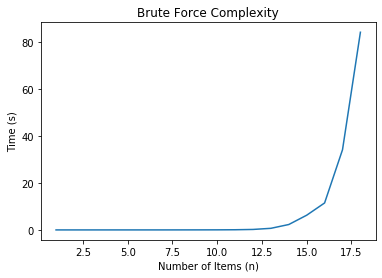

In [37]:
plt.plot(bf_items, bf_time)
plt.xlabel("Number of Items (n)")
plt.ylabel("Time (s)")
plt.title("Brute Force Complexity")
plt.savefig('BF_complexity_n.pdf')

In [38]:
sm_time, sm_items = SM_times(100 ,1 )

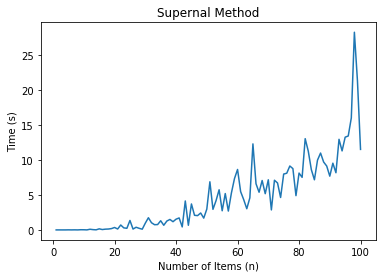

In [41]:
plt.plot(sm_items, sm_time)
plt.xlabel("Number of Items (n)")
plt.ylabel("Time (s)")
plt.title("Supernal Method")
plt.savefig('SM_complexity_n.pdf')

In [39]:
rd_time, rd_items = RD_times(100,1)

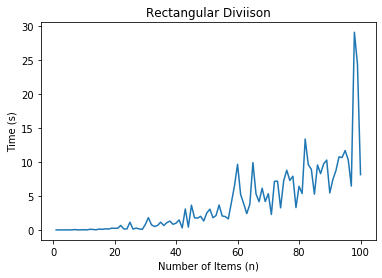

In [42]:
plt.plot(rd_items, rd_time)
plt.xlabel("Number of Items (n)")
plt.ylabel("Time (s)")
plt.title("Rectangular Diviison")
plt.savefig('RD_complexity_n.pdf')

In [63]:
bf_items_new = np.delete(bf_items, 17 )
bf_items_new

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [64]:
bf_times_new = np.delete(bf_time, 17)
bf_times_new

array([2.24828720e-04, 2.53200531e-04, 2.72989273e-04, 8.73088837e-04,
       2.65479088e-03, 2.97713280e-03, 5.34296036e-03, 1.14710331e-02,
       1.98931694e-02, 3.35597992e-02, 7.34536648e-02, 2.00110197e-01,
       6.82349205e-01, 2.30506325e+00, 6.27102017e+00, 1.14993961e+01,
       3.41753390e+01])

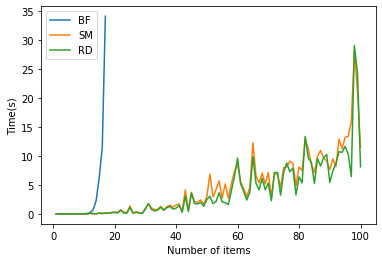

In [67]:
plt.plot(bf_items_new, bf_times_new, label = "BF")
plt.plot(sm_items, sm_time, label = "SM")
plt.plot(rd_items, rd_time, label = "RD")
plt.xlabel('Number of items')
plt.ylabel("Time(s)")
plt.legend()
plt.savefig('Runtime_Comparison.pdf')
plt.show()


In [6]:
def RD_times_c(items, const):
  
    rd_times = []
    rd_num_items = []

    for co in np.arange(1, const+1,2):
        c, a, b = randInstanceGen(items, co, 2, 40)
        #a = a.transpose()
        rd_num_items.append(co)
        start = time.time()
        ndf = rectangularSMART(c,a,b)
        end = time.time() - start
        rd_times.append(end)

        #plt.plot(num_items, times)
        #plt.xlabel("Number of Items (n)")
        #plt.ylabel("Time (s)")
        #plt.title("Brute Force Complexity")
        #plt.savefig('BF_complexity_n.pdf')
    return rd_times, rd_num_items

In [7]:
def SM_times_c(items, const):
  
    sm_times = []
    sm_num_items = []

    for co in np.arange(1, const+1,2):
        c, a, b = randInstanceGen(items, co, 2, 40)
        a = a.transpose()
        sm_num_items.append(co)
        start = time.time()
        ndf = SupernalEff(c,a,b)
        end = time.time() - start
        sm_times.append(end)

        #plt.plot(num_items, times)
        #plt.xlabel("Number of Items (n)")
        #plt.ylabel("Time (s)")
        #plt.title("Brute Force Complexity")
        #plt.savefig('BF_complexity_n.pdf')
    return sm_times, sm_num_items

In [8]:
def BF_times_c(items, const):
  
    bf_times = []
    bf_num_items = []

    for co in np.arange(1, const+1,2):
        c, a, b = randInstanceGen(items, co, 2, 40)
        a = a.transpose()
        bf_num_items.append(co)
        start = time.time()
        ndf = BruteForce(c,a,b)
        end = time.time() - start
        bf_times.append(end)

        #plt.plot(num_items, times)
        #plt.xlabel("Number of Items (n)")
        #plt.ylabel("Time (s)")
        #plt.title("Brute Force Complexity")
        #plt.savefig('BF_complexity_n.pdf')
    return bf_times, bf_num_items

In [9]:
btime, bitem = BF_times_c(15, 100)

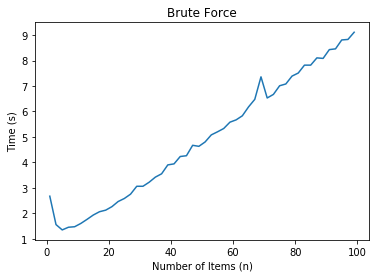

In [10]:
plt.plot(bitem, btime)
plt.xlabel("Number of Items (n)")
plt.ylabel("Time (s)")
plt.title("Brute Force")
plt.savefig('BF_complexity_c.pdf')

In [11]:
stime, sitem = SM_times_c(10, 100)

Using license file C:\Users\Nolan\gurobi.lic
Academic license - for non-commercial use only


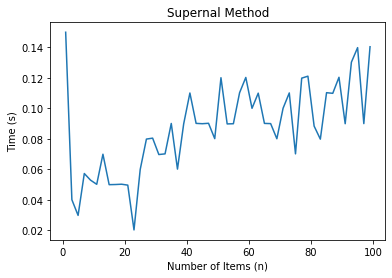

In [12]:
plt.plot(sitem, stime)
plt.xlabel("Number of Items (n)")
plt.ylabel("Time (s)")
plt.title("Supernal Method")
plt.savefig('SM_complexity_c.pdf')

In [13]:
rtime, ritem = RD_times_c(10, 100)

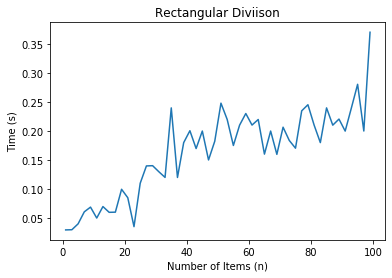

In [14]:
plt.plot(ritem, rtime)
plt.xlabel("Number of Items (n)")
plt.ylabel("Time (s)")
plt.title("Rectangular Diviison")
plt.savefig('RD_complexity_c.pdf')

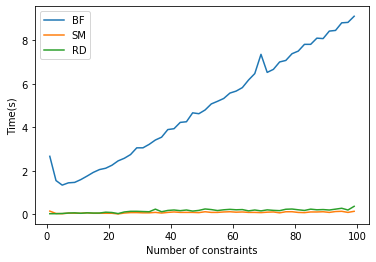

In [15]:
plt.plot(bitem, btime, label = "BF")
plt.plot(sitem, stime, label = "SM")
plt.plot(ritem, rtime, label = "RD")
plt.xlabel('Number of constraints')
plt.ylabel("Time(s)")
plt.legend()
plt.savefig('Runtime_Comparison_const.pdf')
plt.show()